<a href="https://colab.research.google.com/github/FokaKefir/KepKreator/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependecies

In [1]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, Input, Flatten, Reshape, Embedding, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

import sys, os

# disable warnings
tf.get_logger().setLevel('ERROR')

# Preprocess the data

## Load data

In [2]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
x_train = np.concatenate([x_train, x_test])
labels_train = np.concatenate([labels_train, labels_test])

11490434/11490434 [==============================] - 0s 0us/step


## Plot some random examples

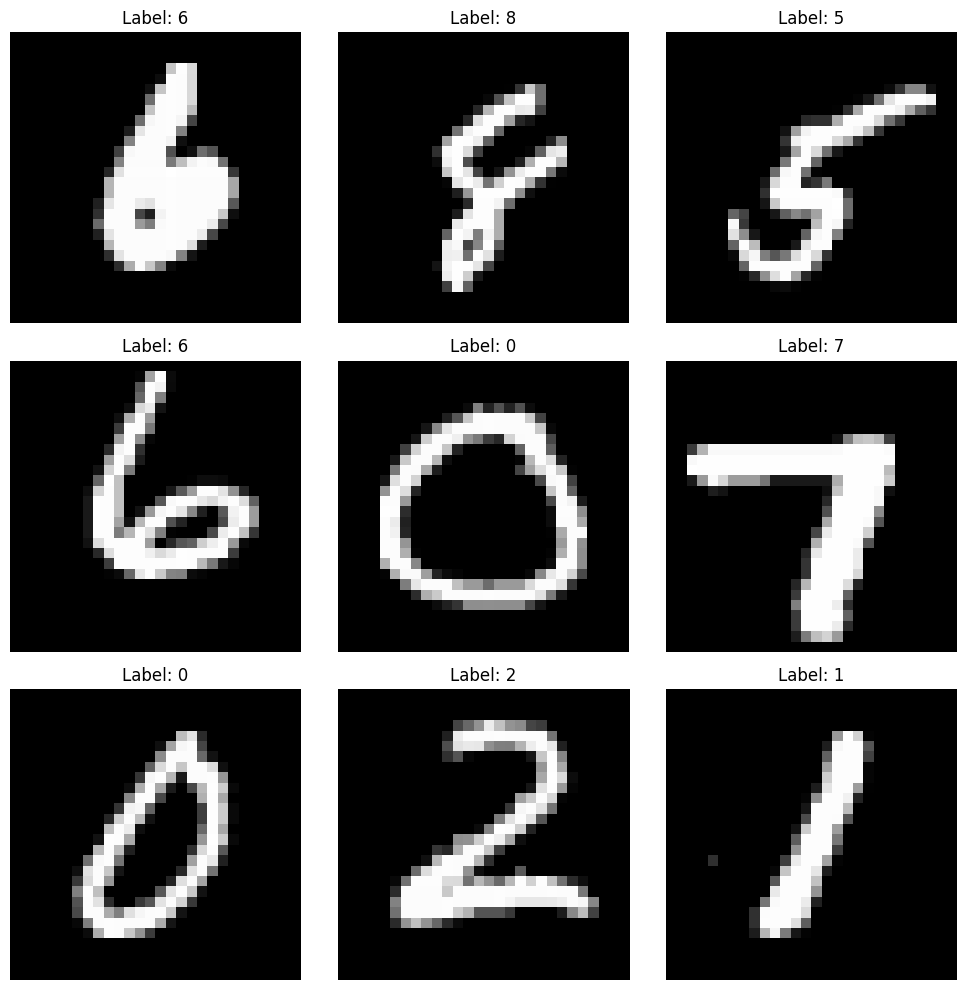

In [3]:
def show_images(examples):
  random_indices = np.random.choice(examples.shape[0], 9, replace=False)

  # rescale images (-1, +1) -> (0, 1)
  examples = 0.5 * examples + 0.5

  plt.figure(figsize=(10, 10))
  for i, index in enumerate(random_indices, 1):
      plt.subplot(3, 3, i)
      plt.imshow(x_train[index], cmap='gray')
      plt.title(f"Label: {labels_train[index]}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

show_images(x_train)

# Define Model


In [9]:
class CGAN(tf.keras.Model):
  def __init__(self, latent_dim, n_classes=10):
    super(CGAN, self).__init__()

    self.latent_dim = latent_dim
    self.n_classes = n_classes

    # create generator
    self.generator = self.build_generator(latent_dim, n_classes)

    # create discriminator
    self.discriminator = self.build_discriminator(n_classes=n_classes)

    # add tracker
    self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
    self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

  @property
  def metrics(self):
    return [self.gen_loss_tracker, self.disc_loss_tracker]

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    tf.config.run_functions_eagerly(True)

    # set optimizers
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer

    # set loss function
    self.loss_fn = loss_fn

    super(CGAN, self).compile()

  def generate_latent_points(self, n_samples):
    x_input = np.random.randn(self.latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, self.latent_dim)
    x_labels = np.random.randint(0, self.n_classes, n_samples)
    return [x_input, x_labels]

  def generate_fake_samples(self, n_samples):
    # generate points in latent space
    x_input, x_labels = self.generate_latent_points(n_samples)

    # predict outputs
    imgs = self.generator([x_input, x_labels])

    # create class labels
    y = np.zeros((n_samples, 1))
    return [imgs, x_labels], y

  @tf.function
  def train_step(self, data):
    # Unpack the data
    real_images, real_labels = data

    # Get batch size
    batch_size = tf.shape(real_images)[0]

    # Get randomly selected 'real' samples, with labels
    x_real, y_real = [real_images, real_labels], np.ones((batch_size, 1))

    # Update discriminator model weights
    with tf.GradientTape() as tape:
      predictions = self.discriminator(x_real)
      d_loss_real = self.loss_fn(y_real, predictions)
    grads = tape.gradient(d_loss_real, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    # Generate 'fake' examples, with labels
    x_fake, y_fake = self.generate_fake_samples(batch_size)

    # Update discriminator model weights
    with tf.GradientTape() as tape:
      predictions = self.discriminator(x_fake)
      d_loss_fake = self.loss_fn(y_fake, predictions)
    grads = tape.gradient(d_loss_fake, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    # Calculate loss and accuracy
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    # Prepare points in latent space as input for the generator
    x_gan = self.generate_latent_points(2 * batch_size)

    # Create inverted labels for the fake samples
    y_gan = np.ones((2 * batch_size, 1))

    # Update the generator via the discriminator's error
    with tf.GradientTape() as tape:
      fake_imgs = self.generator(x_gan)
      fake_imgs_and_labels = [fake_imgs, x_gan[1]]
      predictions = self.discriminator(fake_imgs_and_labels)
      g_loss = self.loss_fn(y_gan, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Monitor loss
    self.gen_loss_tracker.update_state(g_loss)
    self.disc_loss_tracker.update_state(d_loss)

    return {
        "g_loss": self.gen_loss_tracker.result(),
        "d_loss": self.disc_loss_tracker.result(),
    }


  def build_discriminator(self, in_shape=(28, 28, 1), n_classes=10):
    # label input
    i_label = Input(shape=(1, ))
    x_label = Embedding(n_classes, 50)(i_label)
    x_label = Dense(in_shape[0] * in_shape[1], activation='tanh')(x_label)
    x_label = Reshape((in_shape[0], in_shape[1], 1))(x_label)

    # image input
    i_img = Input(shape=in_shape)

    # concatenate
    x = Concatenate()([x_label, i_img])

    # conv layers
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='tanh')(i_img)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='tanh')(x)
    x = Flatten()(x)
    x = Dense(128, activation='tanh')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model([i_img, i_label], x)
    return model

  def build_generator(self, latent_dim, n_classes=10):
    # label input
    i_label = Input(shape=(1, ))
    x_label = Embedding(n_classes, 50)(i_label)
    x_label = Dense(7 * 7 * 3, activation='tanh')(x_label)
    x_label = Reshape((7, 7, 3))(x_label)

    # foundation for 7x7 image
    i_lat = Input(shape=(latent_dim, ))
    x_lat = Dense(7 * 7 * 125, activation='tanh')(i_lat)
    x_lat = Reshape((7, 7, 125))(x_lat)

    # concatenate
    x = Concatenate()([x_lat, x_label])

    # upsample to 14x14
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

    # upsample to 28x28
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

    # make only one color channel, values in (-1, +1)
    x = Conv2D(1, (7, 7), activation='tanh', padding='same')(x)
    return Model([i_lat, i_label], x)

  def sample_images(self, e=0, b=0, method='show'):
    if not os.path.exists('gan_images'):
      os.makedirs('gan_images')

    data, _ = self.generate_fake_samples(25)
    imgs, labels = data
    rows, cols = 5, 5

    # Rescale images (-1, +1) -> (0, 1)
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols, figsize=(9, 10))
    idx = 0
    for i in range(rows):
      for j in range(cols):
        axs[i, j].imshow(imgs[idx], cmap='gray')
        axs[i, j].set_title(f'num: {labels[idx]}')
        axs[i, j].axis('off')
        idx += 1

    if method == 'show':
      plt.show()
    elif method == 'save':
      fig.savefig(f'gan_images/sample_{e:003d}_{b:0004d}.png')
      plt.close()

  # save models
  def save(self, filepath, overwrite=True, save_format=None, **kwargs):
    self.generator.save(filepath + 'generator.h5')
    self.discriminator.save(filepath + 'discriminator.h5')

  # load models
  def load_models(self, generator_path, discriminator_path):
    self.generator = load_model(generator_path, compile=False)
    self.discriminator = load_model(discriminator_path, compile=False)


# Train the Model

## Define callbacks


In [10]:
checkpointer = ModelCheckpoint(
    'models/{epoch:002d}/',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq=100
)

In [11]:
class SamplerCallback(tf.keras.callbacks.Callback):
  def __init__(self, sample_freq: int=1):
    super().__init__()
    self.sample_freq = sample_freq
    self.e = 0

  def on_epoch_begin(self, epoch, logs=None):
    self.e = epoch

  def on_train_batch_end(self, batch: int, logs=None):
    if batch % self.sample_freq == 0:
      self.model.sample_images(self.e + 1, batch, method='save')

sampler = SamplerCallback(sample_freq=100)

In [12]:
import gc

class GarbageCollectorCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

garbage_collector = GarbageCollectorCallback()

## Create models and train


In [13]:
cgan = CGAN(latent_dim=100, n_classes=10)

cgan.compile(
    d_optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=BinaryCrossentropy(from_logits=True)
)

cgan.fit(
    x_train, labels_train,
    epochs=10,
    batch_size=32,
    callbacks=[
        checkpointer,
        sampler,
        garbage_collector
    ]
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 100/2188 [>.............................] - ETA: 5:22 - g_loss: 0.9269 - d_loss: 0.4836

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2188/2188 [==============================] - 383s 170ms/step - g_loss: 0.7972 - d_loss: 0.6876
Epoch 2/10
2188/2188 [==============================] - 359s 164ms/step - g_loss: 1.2165 - d_loss: 0.4984
Epoch 3/10
2188/2188 [==============================] - 359s 164ms/step - g_loss: 1.1500 - d_loss: 0.5345
Epoch 4/10
2188/2188 [==============================] - 358s 163ms/step - g_loss: 1.1624 - d_loss: 0.5368
Epoch 5/10
2188/2188 [==============================] - 349s 159ms/step - g_loss: 1.1814 - d_loss: 0.5375
Epoch 6/10
2188/2188 [==============================] - 350s 160ms/step - g_loss: 1.1801 - d_loss: 0.5392
Epoch 7/10
2188/2188 [==============================] - 350s 160ms/step - g_loss: 1.1840 - d_loss: 0.5366
Epoch 8/10
2188/2188 [==============================] - 350s 160ms/step - g_loss: 1.1804 - d_loss: 0.5411
Epoch 9/10
2188/2188 [==============================] - 351s 160ms/step - g_loss: 1.1731 - d_loss: 0.5456
Epoch 10/10
2188/2188 [==============================] - 

# Load model

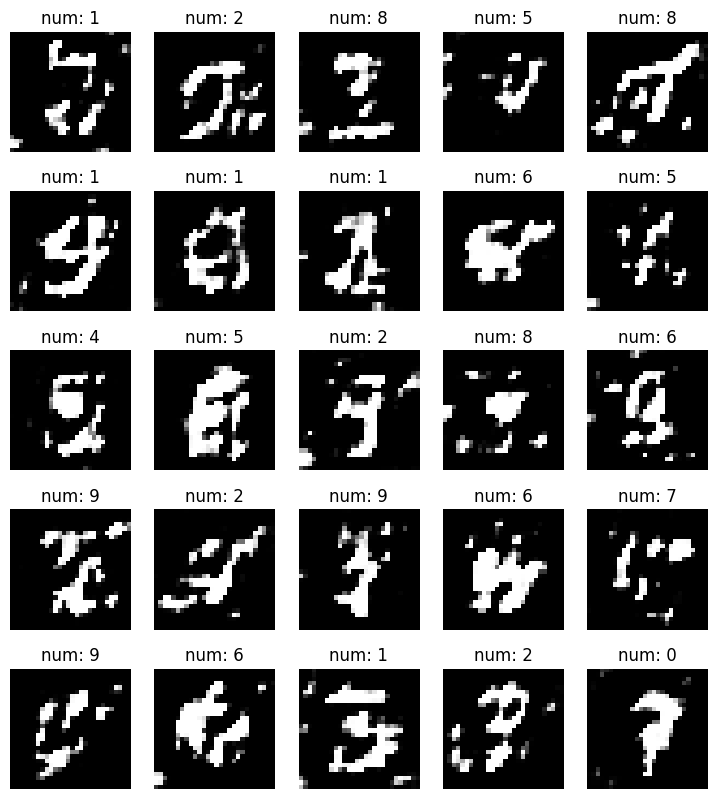

In [14]:
e = 1
cgan = CGAN(latent_dim=100, n_classes=10)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

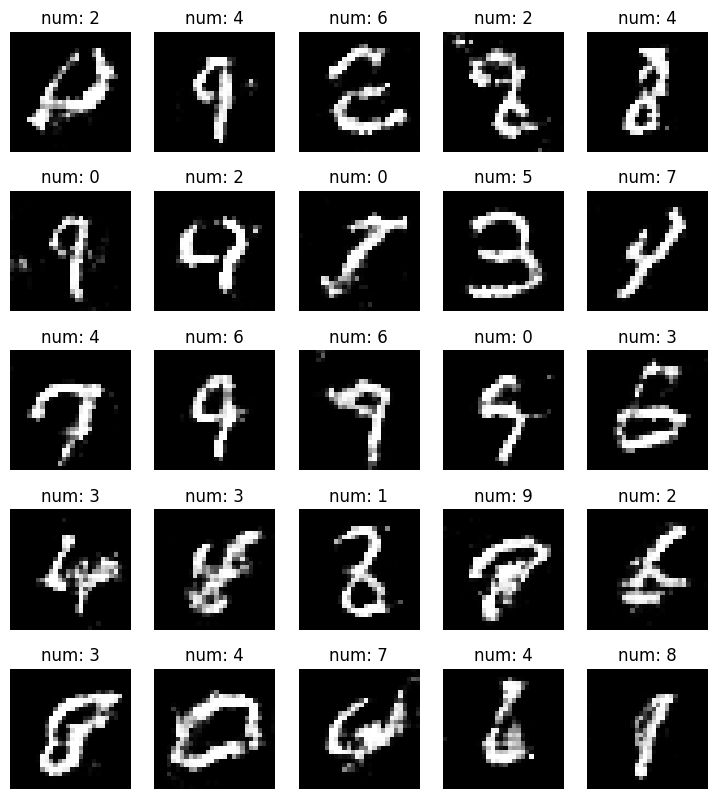

In [15]:
e = 3
cgan = CGAN(latent_dim=100, n_classes=10)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

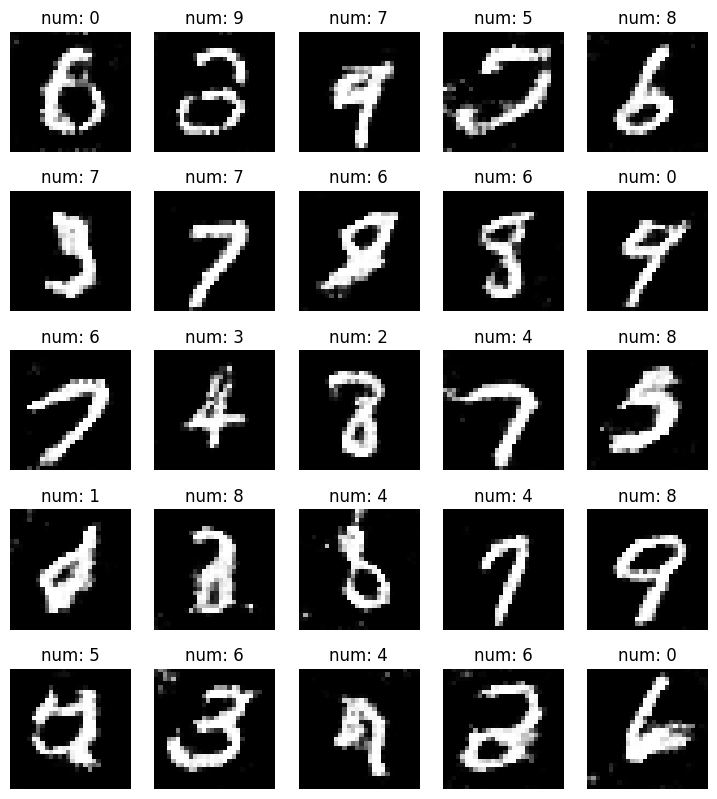

In [16]:
e = 5
cgan = CGAN(latent_dim=100, n_classes=10)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

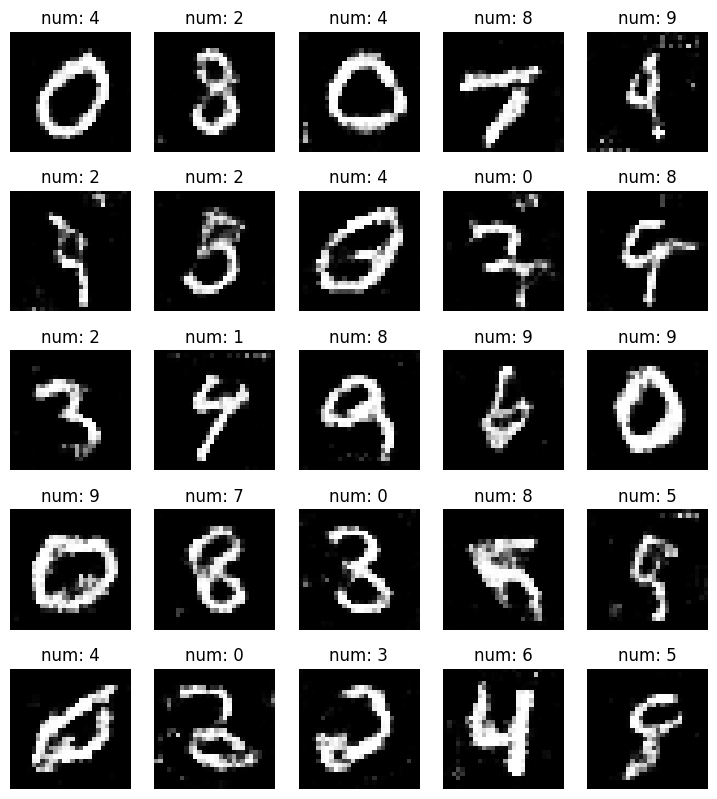

In [17]:
e = 7
cgan = CGAN(latent_dim=100, n_classes=10)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

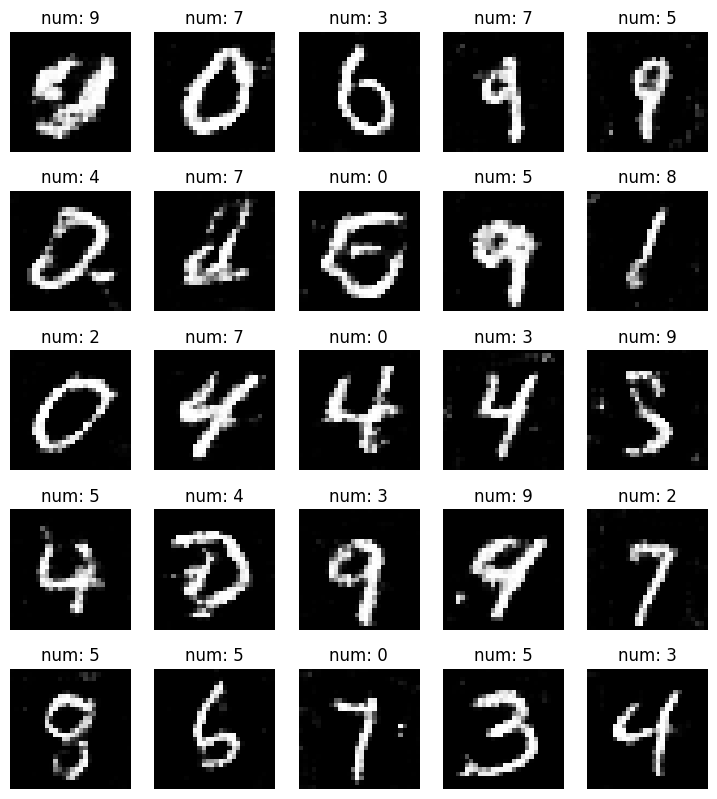

In [18]:
e = 9
cgan = CGAN(latent_dim=100, n_classes=10)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

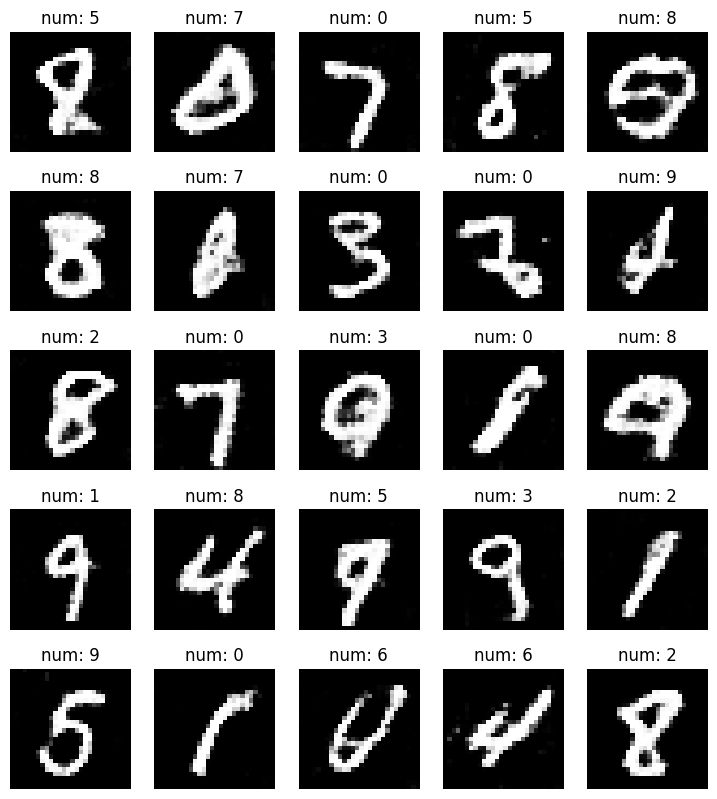

In [19]:
e = 10
cgan = CGAN(latent_dim=100, n_classes=10)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

# Download models

In [20]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/01/ (stored 0%)
  adding: content/models/01/discriminator.h5 (deflated 9%)
  adding: content/models/01/generator.h5 (deflated 8%)
  adding: content/models/07/ (stored 0%)
  adding: content/models/07/discriminator.h5 (deflated 9%)
  adding: content/models/07/generator.h5 (deflated 8%)
  adding: content/models/06/ (stored 0%)
  adding: content/models/06/discriminator.h5 (deflated 9%)
  adding: content/models/06/generator.h5 (deflated 8%)
  adding: content/models/09/ (stored 0%)
  adding: content/models/09/discriminator.h5 (deflated 9%)
  adding: content/models/09/generator.h5 (deflated 8%)
  adding: content/models/10/ (stored 0%)
  adding: content/models/10/discriminator.h5 (deflated 9%)
  adding: content/models/10/generator.h5 (deflated 8%)
  adding: content/models/03/ (stored 0%)
  adding: content/models/03/discriminator.h5 (deflated 9%)
  adding: content/models/03/generator.h5 (deflated 8%)
  adding: content/models/05/ (st

In [21]:
from google.colab import files
files.download("/content/models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>